In [2]:
!pip install mpl_finance

In [5]:
!pip install --upgrade mplfinance

In [18]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import matplotlib as mpl
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as dates
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

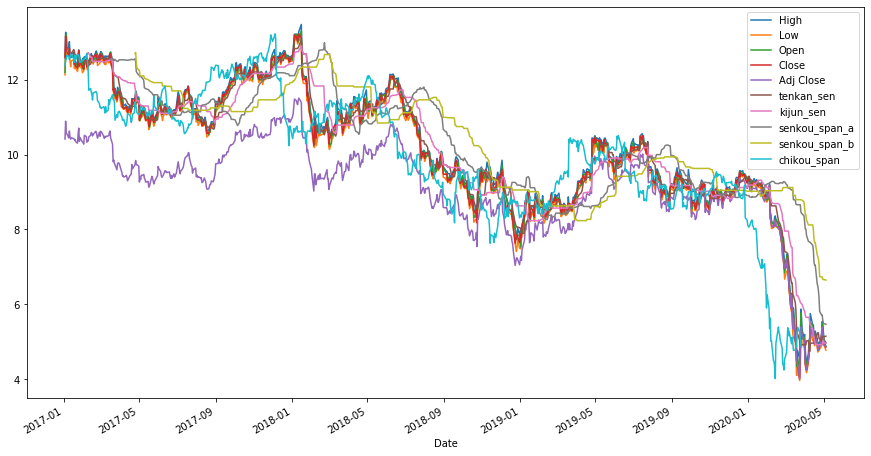

In [10]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2020,5,4)
d=data.DataReader("F", 'yahoo', start, end)

# convert dates to integer values for later use with the 
# matplotlib candlestick charting function (it doesn't accept datetimes)
d['Dates'] = dates.date2num(d.index)

# Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
nine_period_high = d['High'].rolling(window= 9).max()
nine_period_low = d['Low'].rolling(window= 9).min()
d['tenkan_sen'] = (nine_period_high + nine_period_low) /2

# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = d['High'].rolling(window=26).max()
period26_low = d['Low'].rolling(window=26).min()
d['kijun_sen'] = (period26_high + period26_low) / 2

# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)

# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = d['High'].rolling(window=52).max()
period52_low = d['Low'].rolling(window=52).min()
d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)

# The most current closing price plotted 26 time periods behind (optional)
d['chikou_span'] = d['Close'].shift(-26)

# create a quick plot of the results to see what we have created
d.drop(['Dates', 'Volume'], axis=1).plot(figsize=(15,8))
plt.show()

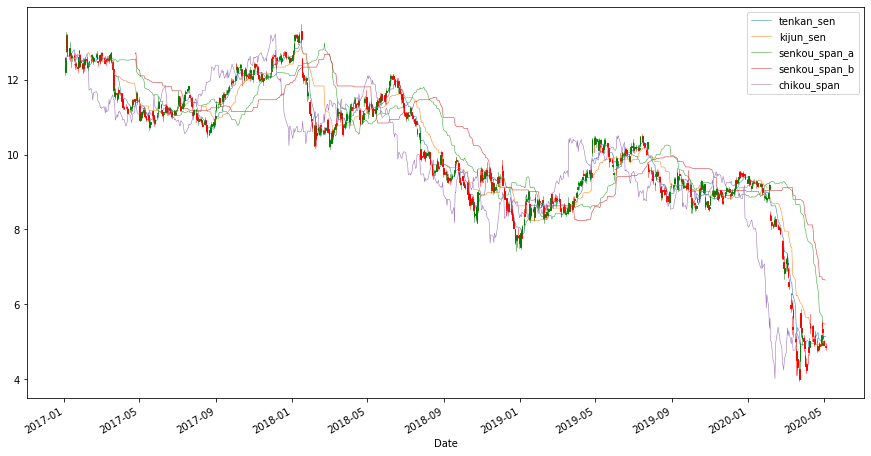

In [11]:
# Re-arrange data so that each row contains values of a day: 'Date','Open','High','Low','Close'.
# The 'Date' can't be a "datetime" object as the function wont accept them. That's why we converted 
# our 'Date' column into integer values using the "date2num" function earlier.
quotes = [tuple(x) for x in d[['Dates','Open','High','Low','Close']].values]

# Plot candlestick, along with Ichimoku elements
fig, ax = plt.subplots(figsize=(15,8))
d[['tenkan_sen','kijun_sen','senkou_span_a','senkou_span_b','chikou_span']].plot(ax=ax, linewidth=0.5)
candlestick_ohlc(ax, quotes, width=1.0, colorup='g', colordown='r');

In [14]:
!pip install chart_studio

In [15]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
trace = go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['High'],
                low=d['Low'],
                close=d['Close'])
data = [trace]
iplot(data, filename='simple_candlestick')

In [16]:
# Set colors for up and down candles
INCREASING_COLOR = '#17BECF'
DECREASING_COLOR = '#7F7F7F'

# create list to hold dictionary with data for our first series to plot
# (which is the candlestick element itself)
data = [ dict(
    type = 'candlestick',
    open = d.Open,
    high = d.High,
    low = d.Low,
    close = d.Close,
    x = d.index,
    yaxis = 'y2',
    name = 'F',
    increasing = dict( line = dict( color = INCREASING_COLOR ) ),
    decreasing = dict( line = dict( color = DECREASING_COLOR ) ),
) ]

# Create empty dictionary for later use to hold settings and layout options
layout=dict()

# create our main chart "Figure" object which consists of data to plot and layout settings
fig = dict( data=data, layout=layout )

# Assign various seeting and choices - background colour, range selector etc
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )


# Populate the "rangeselector" object with necessary settings
rangeselector=dict(
    visible = True,
    x = 0, y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict( size = 13 ),
    buttons=list([
        dict(count=1,
             label='reset',
             step='all'),
        dict(count=1,
             label='1yr',
             step='year',
             stepmode='backward'),
        dict(count=3,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
    

fig['layout']['xaxis']['rangeselector'] = rangeselector

# Append the Ichimoku elements to the plot
fig['data'].append( dict( x=d['tenkan_sen'].index, y=d['tenkan_sen'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#33BDFF' ),
                         yaxis = 'y2', name='tenkan_sen' ) )

fig['data'].append( dict( x=d['kijun_sen'].index, y=d['kijun_sen'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#F1F316' ),
                         yaxis = 'y2', name='kijun_sen' ) )

fig['data'].append( dict( x=d['senkou_span_a'].index, y=d['senkou_span_a'], type='scatter', mode='lines', 
                         line = dict( width = 1 ), 
                         marker = dict( color = '#228B22' ),
                         yaxis = 'y2', name='senkou_span_a' ) )

fig['data'].append( dict( x=d['senkou_span_b'].index, y=d['senkou_span_b'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),fill='tonexty',
                         marker = dict( color = '#FF3342' ),
                         yaxis = 'y2', name='senkou_span_b' ) )

fig['data'].append( dict( x=d['chikou_span'].index, y=d['chikou_span'], type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#D105F5' ),
                         yaxis = 'y2', name='chikou_span' ) )


# Set colour list for candlesticks
colors = []

for i in range(len(d.Close)):
    if i != 0:
        if d.Close[i] > d.Close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)
        
iplot( fig, filename = 'candlestick-ichimoku' )

In [19]:
d.dropna(inplace=True)

d['above_cloud'] = 0
d['above_cloud'] = np.where((d['Low'] > d['senkou_span_a'])  & (d['Low'] > d['senkou_span_b'] ), 1, d['above_cloud'])
d['above_cloud'] = np.where((d['High'] < d['senkou_span_a']) & (d['High'] < d['senkou_span_b']), -1, d['above_cloud'])

d['A_above_B'] = np.where((d['senkou_span_a'] > d['senkou_span_b']), 1, -1)

In [20]:
d['tenkan_kiju_cross'] = np.NaN
d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) <= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] > d['kijun_sen']), 1, d['tenkan_kiju_cross'])
d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) >= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] < d['kijun_sen']), -1, d['tenkan_kiju_cross'])

d['price_tenkan_cross'] = np.NaN
d['price_tenkan_cross'] = np.where((d['Open'].shift(1) <= d['tenkan_sen'].shift(1)) & (d['Open'] > d['tenkan_sen']), 1, d['price_tenkan_cross'])
d['price_tenkan_cross'] = np.where((d['Open'].shift(1) >= d['tenkan_sen'].shift(1)) & (d['Open'] < d['tenkan_sen']), -1, d['price_tenkan_cross'])

In [21]:
d['buy'] = np.NaN
d['buy'] = np.where((d['above_cloud'].shift(1) == 1) & (d['A_above_B'].shift(1) == 1) & ((d['tenkan_kiju_cross'].shift(1) == 1) | (d['price_tenkan_cross'].shift(1) == 1)), 1, d['buy'])
d['buy'] = np.where(d['tenkan_kiju_cross'].shift(1) == -1, 0, d['buy'])
d['buy'].ffill(inplace=True)


d['sell'] = np.NaN
d['sell'] = np.where((d['above_cloud'].shift(1) == -1) & (d['A_above_B'].shift(1) == -1) & ((d['tenkan_kiju_cross'].shift(1) == -1) | (d['price_tenkan_cross'].shift(1) == -1)), -1, d['sell'])
d['sell'] = np.where(d['tenkan_kiju_cross'].shift(1) == 1, 0, d['sell'])
d['sell'].ffill(inplace=True)

d['position'] = d['buy'] + d['sell']

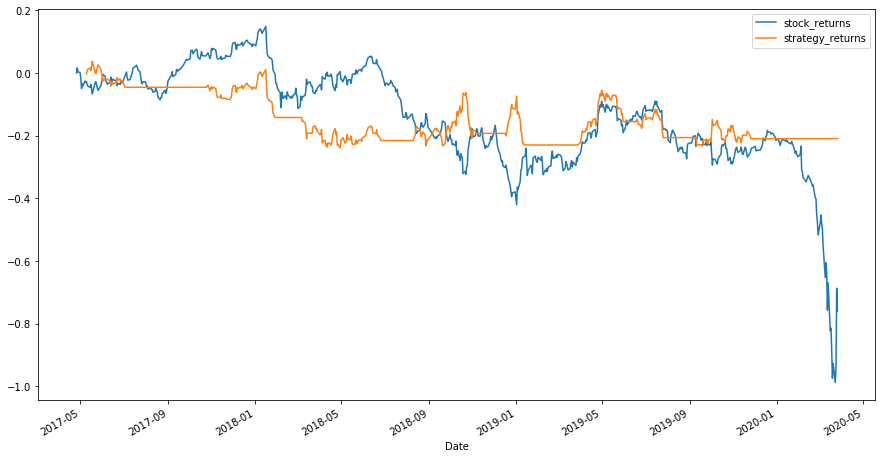

In [22]:
d['stock_returns'] = np.log(d['Open']) - np.log(d['Open'].shift(1))
d['strategy_returns'] = d['stock_returns'] * d['position']

d[['stock_returns','strategy_returns']].cumsum().plot(figsize=(15,8))

In [23]:
def ichimoku(ticker, start, end):

    d=data.DataReader(ticker, 'yahoo', start, end)[['Open','High','Low','Close']]

    # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
    nine_period_high = d['High'].rolling(window= 9).max()
    nine_period_low = d['Low'].rolling(window= 9).min()
    d['tenkan_sen'] = (nine_period_high + nine_period_low) /2

    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    period26_high = d['High'].rolling(window=26).max()
    period26_low = d['Low'].rolling(window=26).min()
    d['kijun_sen'] = (period26_high + period26_low) / 2

    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)

    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    period52_high = d['High'].rolling(window=52).max()
    period52_low = d['Low'].rolling(window=52).min()
    d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(52)

    # The most current closing price plotted 26 time periods behind (optional)
    d['chikou_span'] = d['Close'].shift(-26)

    d.dropna(inplace=True)

    d['above_cloud'] = 0
    d['above_cloud'] = np.where((d['Low'] > d['senkou_span_a'])  & (d['Low'] > d['senkou_span_b'] ), 1, d['above_cloud'])
    d['above_cloud'] = np.where((d['High'] < d['senkou_span_a']) & (d['High'] < d['senkou_span_b']), -1, d['above_cloud'])

    d['A_above_B'] = np.where((d['senkou_span_a'] > d['senkou_span_b']), 1, -1)

    d['tenkan_kiju_cross'] = np.NaN
    d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) <= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] > d['kijun_sen']), 1, d['tenkan_kiju_cross'])
    d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) >= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] < d['kijun_sen']), -1, d['tenkan_kiju_cross'])

    d['price_tenkan_cross'] = np.NaN
    d['price_tenkan_cross'] = np.where((d['Open'].shift(1) <= d['tenkan_sen'].shift(1)) & (d['Open'] > d['tenkan_sen']), 1, d['price_tenkan_cross'])
    d['price_tenkan_cross'] = np.where((d['Open'].shift(1) >= d['tenkan_sen'].shift(1)) & (d['Open'] < d['tenkan_sen']), -1, d['price_tenkan_cross'])

    d['buy'] = np.NaN
    d['buy'] = np.where((d['above_cloud'].shift(1) == 1) & (d['A_above_B'].shift(1) == 1) & ((d['tenkan_kiju_cross'].shift(1) == 1) | (d['price_tenkan_cross'].shift(1) == 1)), 1, d['buy'])
    d['buy'] = np.where(d['tenkan_kiju_cross'].shift(1) == -1, 0, d['buy'])
    d['buy'].ffill(inplace=True)


    d['sell'] = np.NaN
    d['sell'] = np.where((d['above_cloud'].shift(1) == -1) & (d['A_above_B'].shift(1) == -1) & ((d['tenkan_kiju_cross'].shift(1) == -1) | (d['price_tenkan_cross'].shift(1) == -1)), -1, d['sell'])
    d['sell'] = np.where(d['tenkan_kiju_cross'].shift(1) == 1, 0, d['sell'])
    d['sell'].ffill(inplace=True)

    d['position'] = d['buy'] + d['sell']

    d['stock_returns'] = np.log(d['Open']) - np.log(d['Open'].shift(1))
    d['strategy_returns'] = d['stock_returns'] * d['position']

    d[['stock_returns','strategy_returns']].cumsum().plot(figsize=(15,8))

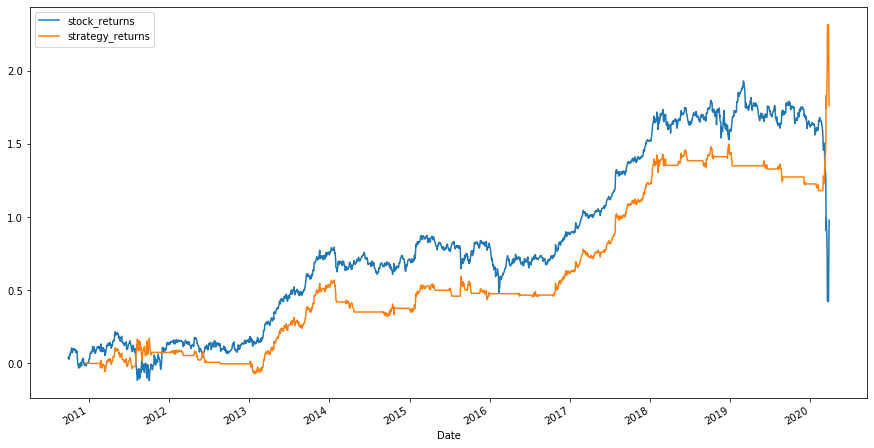

In [30]:
ticker = 'ba'
start = datetime.datetime(2010, 5, 4)
end = datetime.datetime(2020, 5, 4)

ichimoku(ticker, start, end)